In [1]:
import cv2
import numpy as np
import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

---
# Camera Calibration

In [ ]:
def calibrate_camera(images, display=True):
    """
    """
    
    # board dimensions
    BOARD_X = 9
    BOARD_Y = 6
    
    # object = real undistorted grid
    objpoints = [] # 3D points IRL space
    imgpoints = [] # 2D points in image plane

    # looping through images to gather object and image points 
    for i in images:
        img = cv2.imread(i)
        # we need calibration images in grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # preparing object points
        # they all have  Z=0
        # so we only generate X,Y coordinates for OBJECT grid corners
        objp = np.zeros((BOARD_X * BOARD_Y, 3), np.float32)
        objp[:,:2] = np.mgrid[0:BOARD_X, 0:BOARD_Y].T.reshape(-1,2)

        # detecting chessboard corners in image
        ret, corners = cv2.findChessboardCorners(gray, (BOARD_X,BOARD_Y), None)

        # adding object and image points if corners are found
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)

            # drawing and displaying corners
            img_corners = cv2.drawChessboardCorners(img, (BOARD_X,BOARD_Y), corners, ret)
            if display:
                plt.figure()
                plt.imshow(img_corners)
    
    # time to actually calibrate the camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    if ret:
        return mtx, dist
    return None,None

In [ ]:
images = glob.glob('camera_cal/calibration*.jpg')

cam_mtx, cam_dist = calibrate_camera(images, False)

In [ ]:
from random import randint 
i = images[randint(0,20)]
img = cv2.imread(i)
dst = cv2.undistort(img, cam_mtx, cam_dist, None, cam_mtx)
plt.imshow(img)
plt.figure()
plt.imshow(dst)    

---
# Pipeline
## Distortion Correction

## Color & Gradient Threshold

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    direction = (1,0) if orient=='x' else (0,1)
    sobel = cv2.Sobel(gray, cv2.CV_64F, direction[0], direction[1])
    
    # Calculate directional gradient
    sobel_abs = np.absolute(sobel)
    sobel_norm = np.uint8(255*sobel_abs / np.max(sobel_abs))
    
    # Apply threshold
    grad_binary = np.zeros_like(sobel_norm)
    #grad_binary[(sobel_norm > thresh_min) & (sobel_norm < thresh_max)] = 1
    grad_binary[(sobel_norm > thresh[0]) & (sobel_norm < thresh[1])] = 1
    
    return grad_binary

In [3]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate gradient magnitude
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag_norm = np.uint8(255*mag/np.max(mag))
    
    # Apply threshold
    mag_binary = np.zeros_like(mag_norm)
    mag_binary[(mag_norm >= mag_thresh[0]) & (mag_norm <= mag_thresh[1])] = 1
    
    return mag_binary

In [4]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # Calculate gradient direction
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    
    return dir_binary

In [5]:
image = cv2.imread('test_images/test1.jpg')

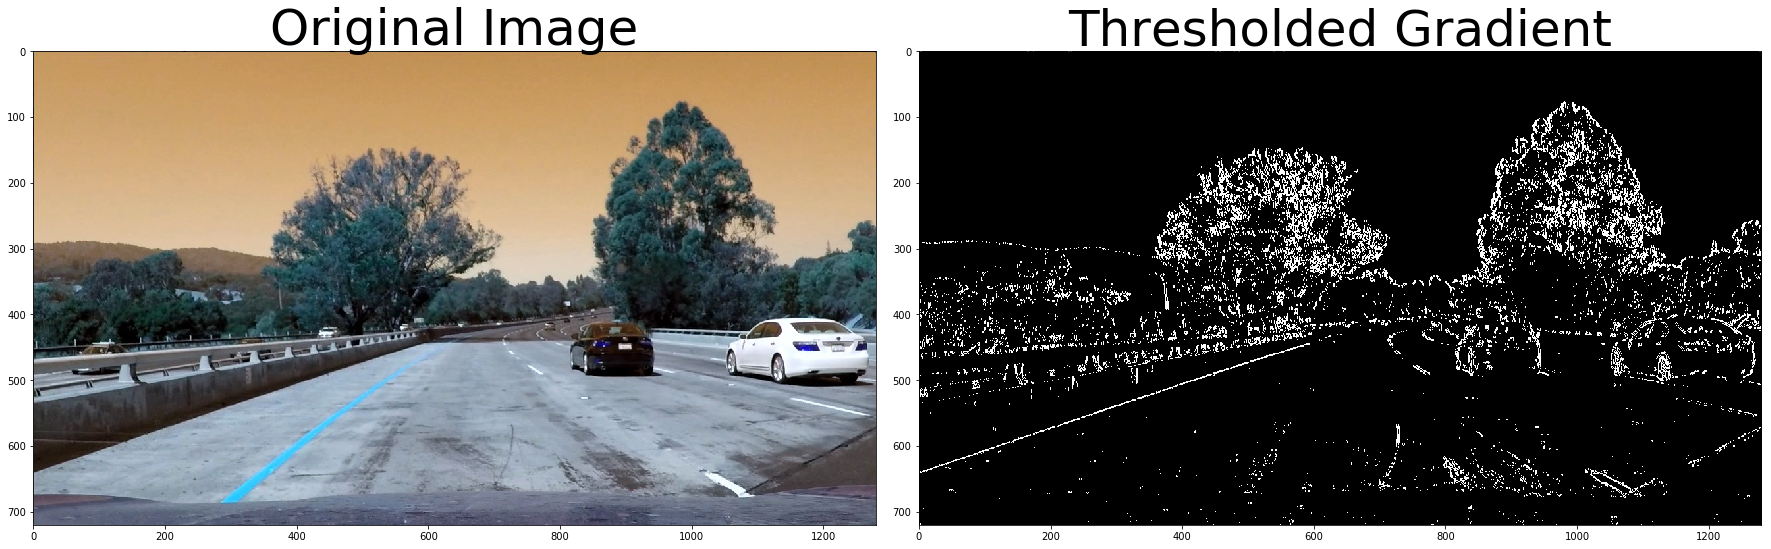

In [6]:
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh=(20,100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

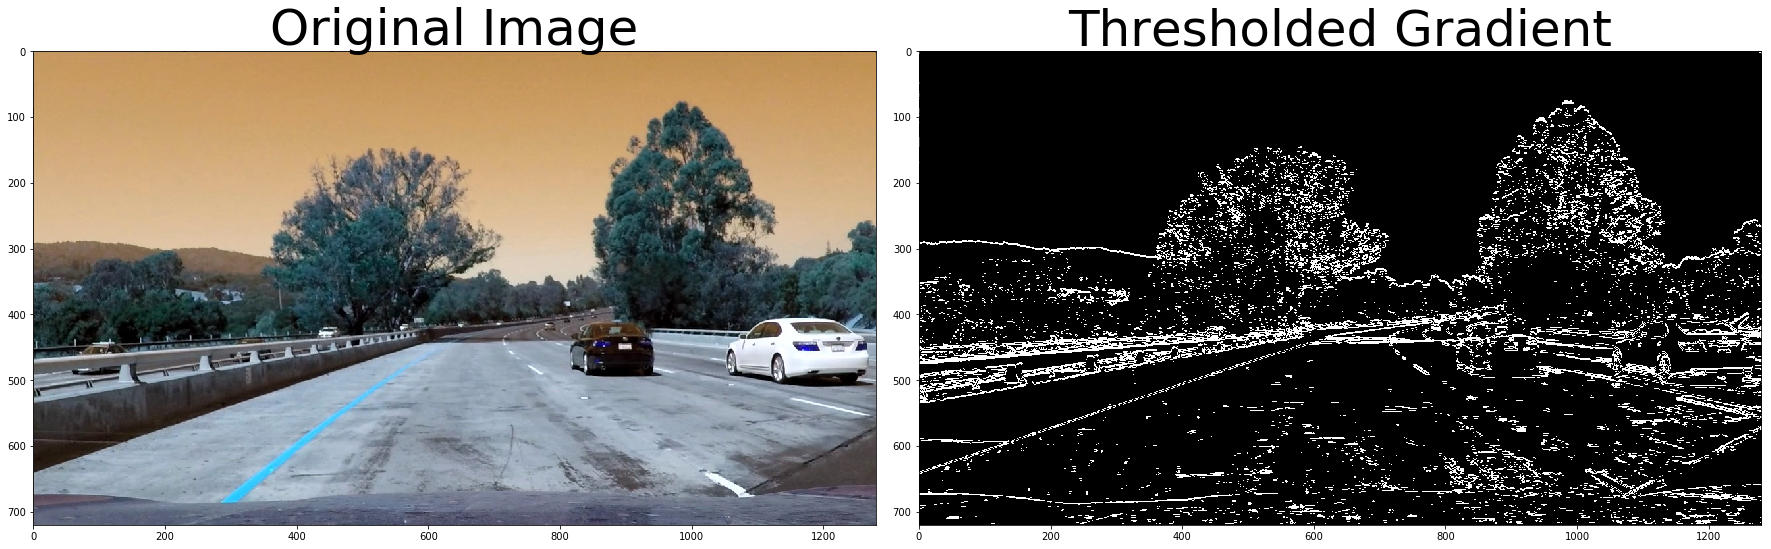

In [7]:
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh=(20,100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_y, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

NameError: name 'img' is not defined

In [ ]:
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

## Perspective Transform

---
# Lane Finding